# Test Benchmarking

This file is to test some benchmarking of the $\mathcal{O}(n^2)$ implementation of the t-SNE algorithm.

In [6]:
import numpy as np
#import matplotlib.pyplot as plt
%matplotlib inline

from visualization import *
from util_tsne_exact import FUNCTION_NAMES, read_benchmark_exact
from util_tsne_bh import read_benchmark_bh

Read the data.

In [2]:
N, total_flops, flops_by_function, cycles = read_benchmark_exact("../implementations/tsne_exact/benchmarking/20170502_100055@-O3 -march=native@")

Plot the performance plot.

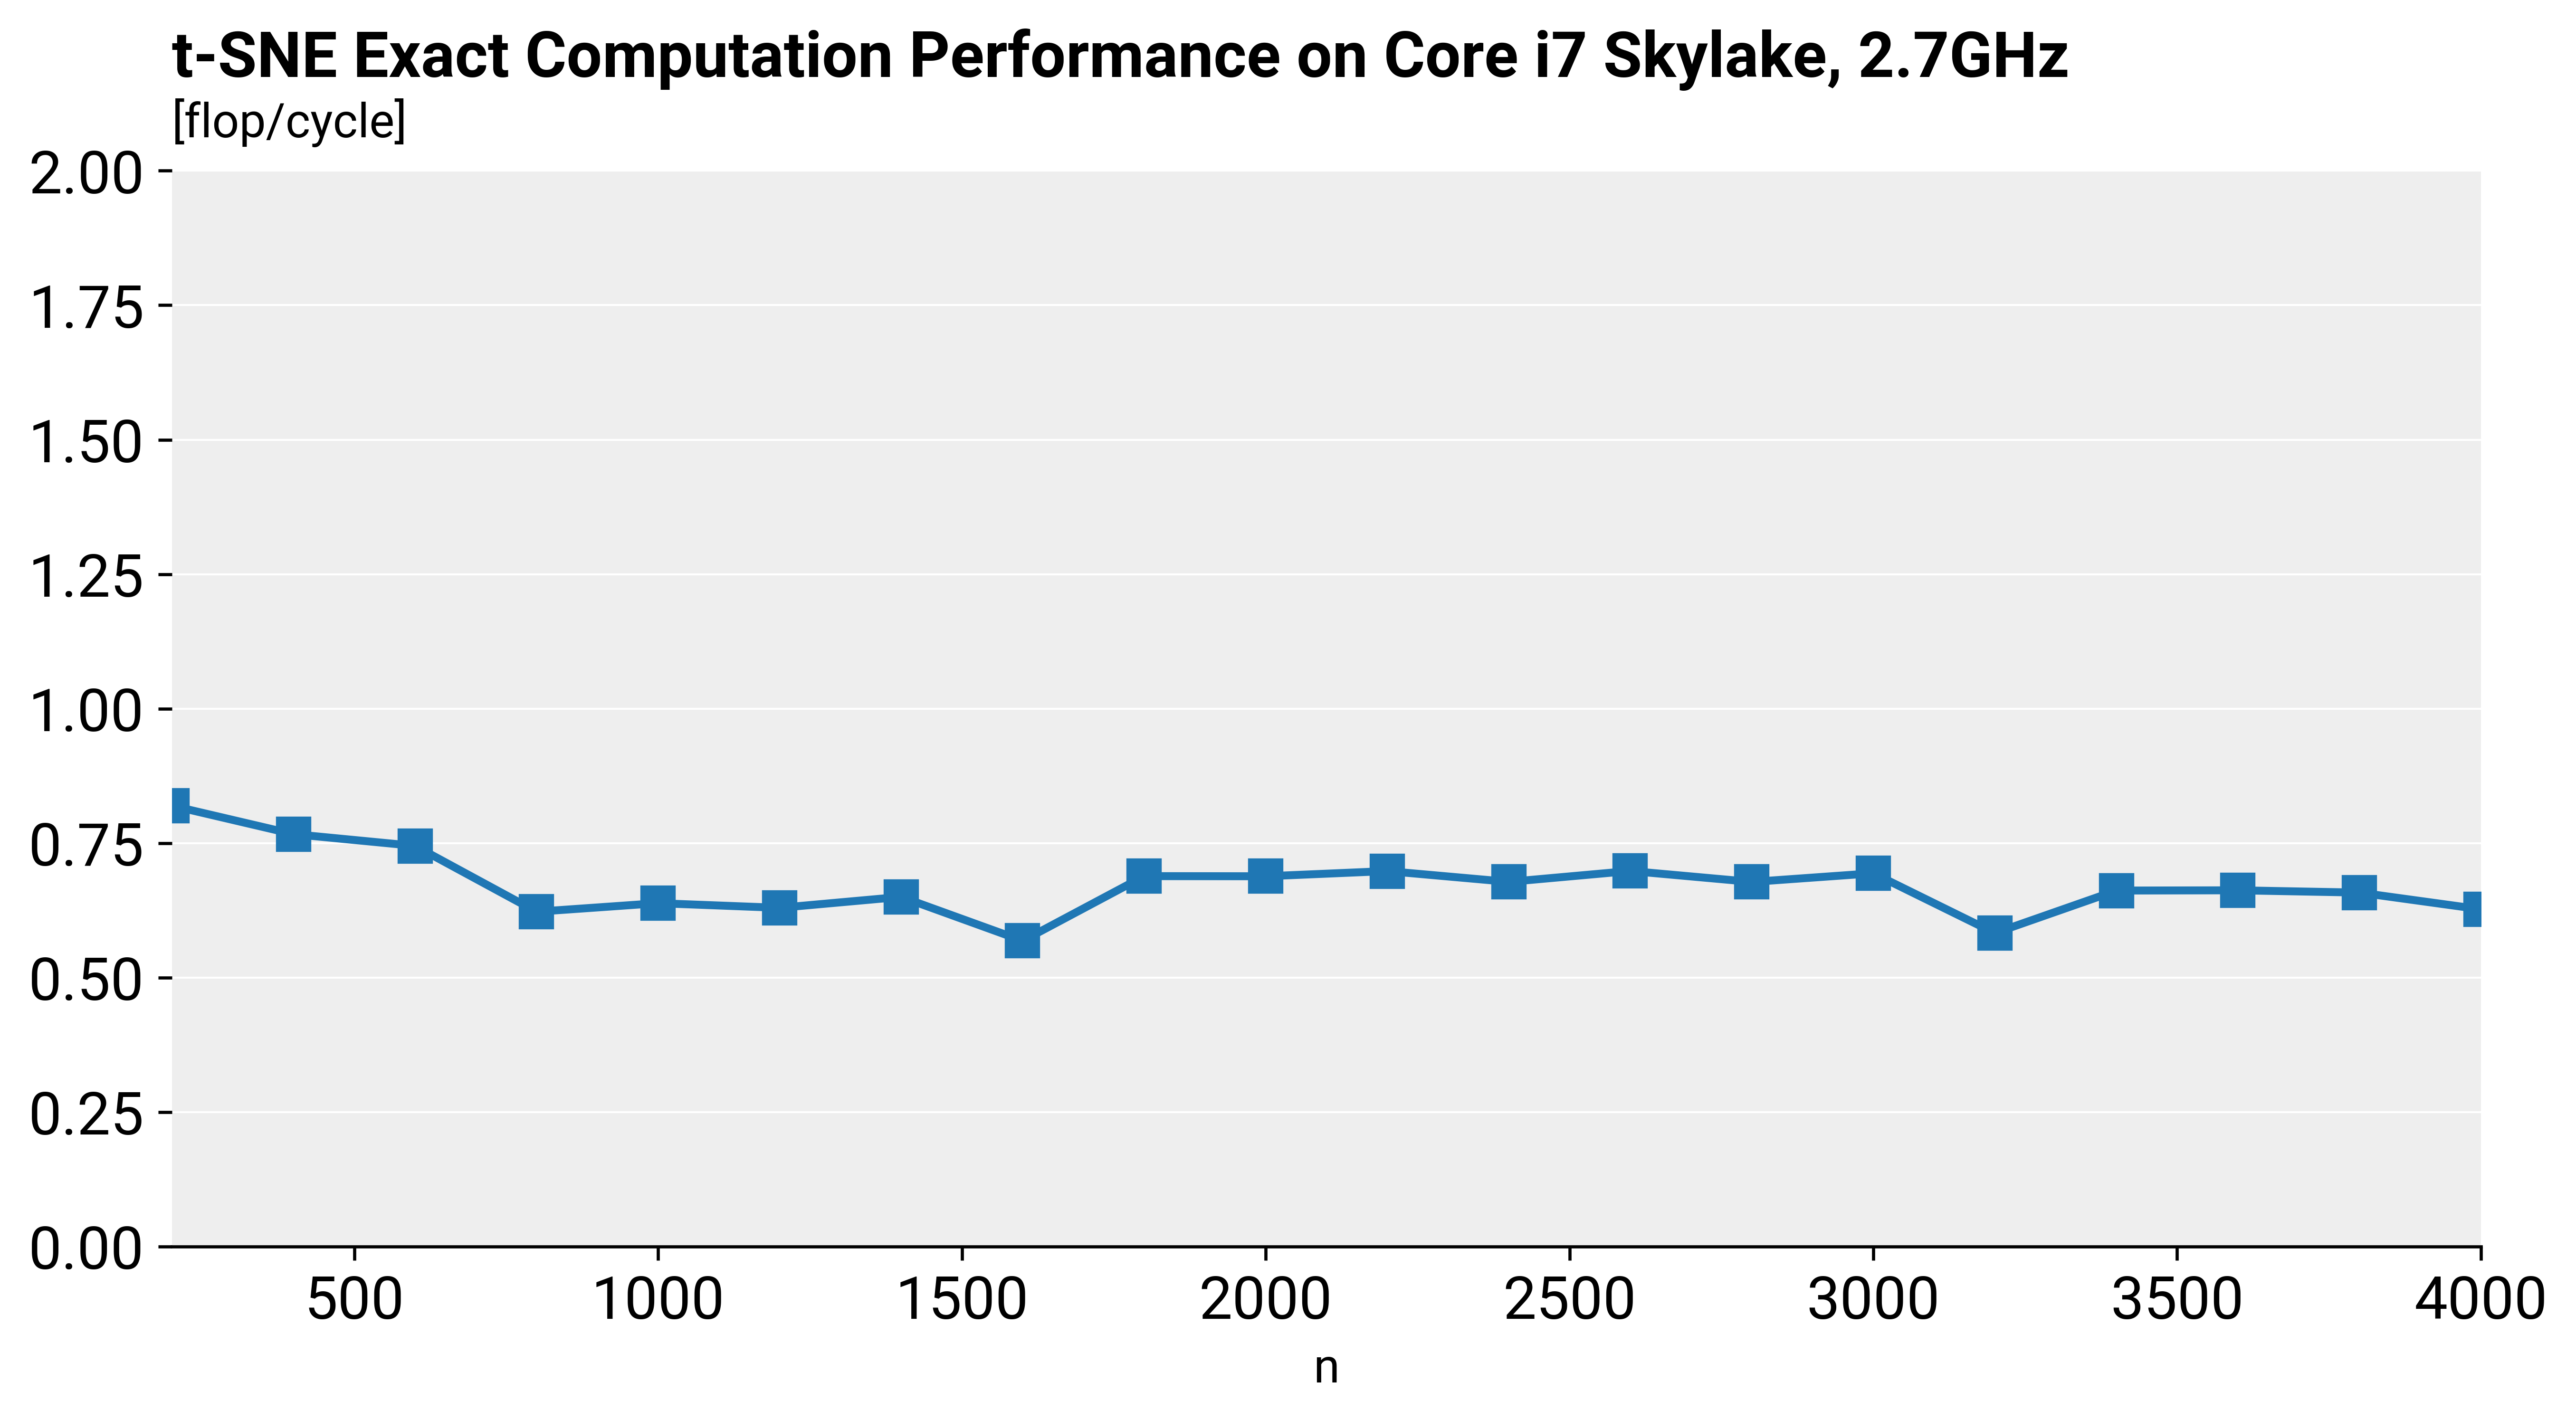

In [3]:
performance_total = total_flops / cycles[:,-1]

title = "t-SNE Exact Computation Performance on Core i7 Skylake, 2.7GHz"
plot(N, performance_total, title=title)
plt.show()

Now separate the performance by each algorithm function.

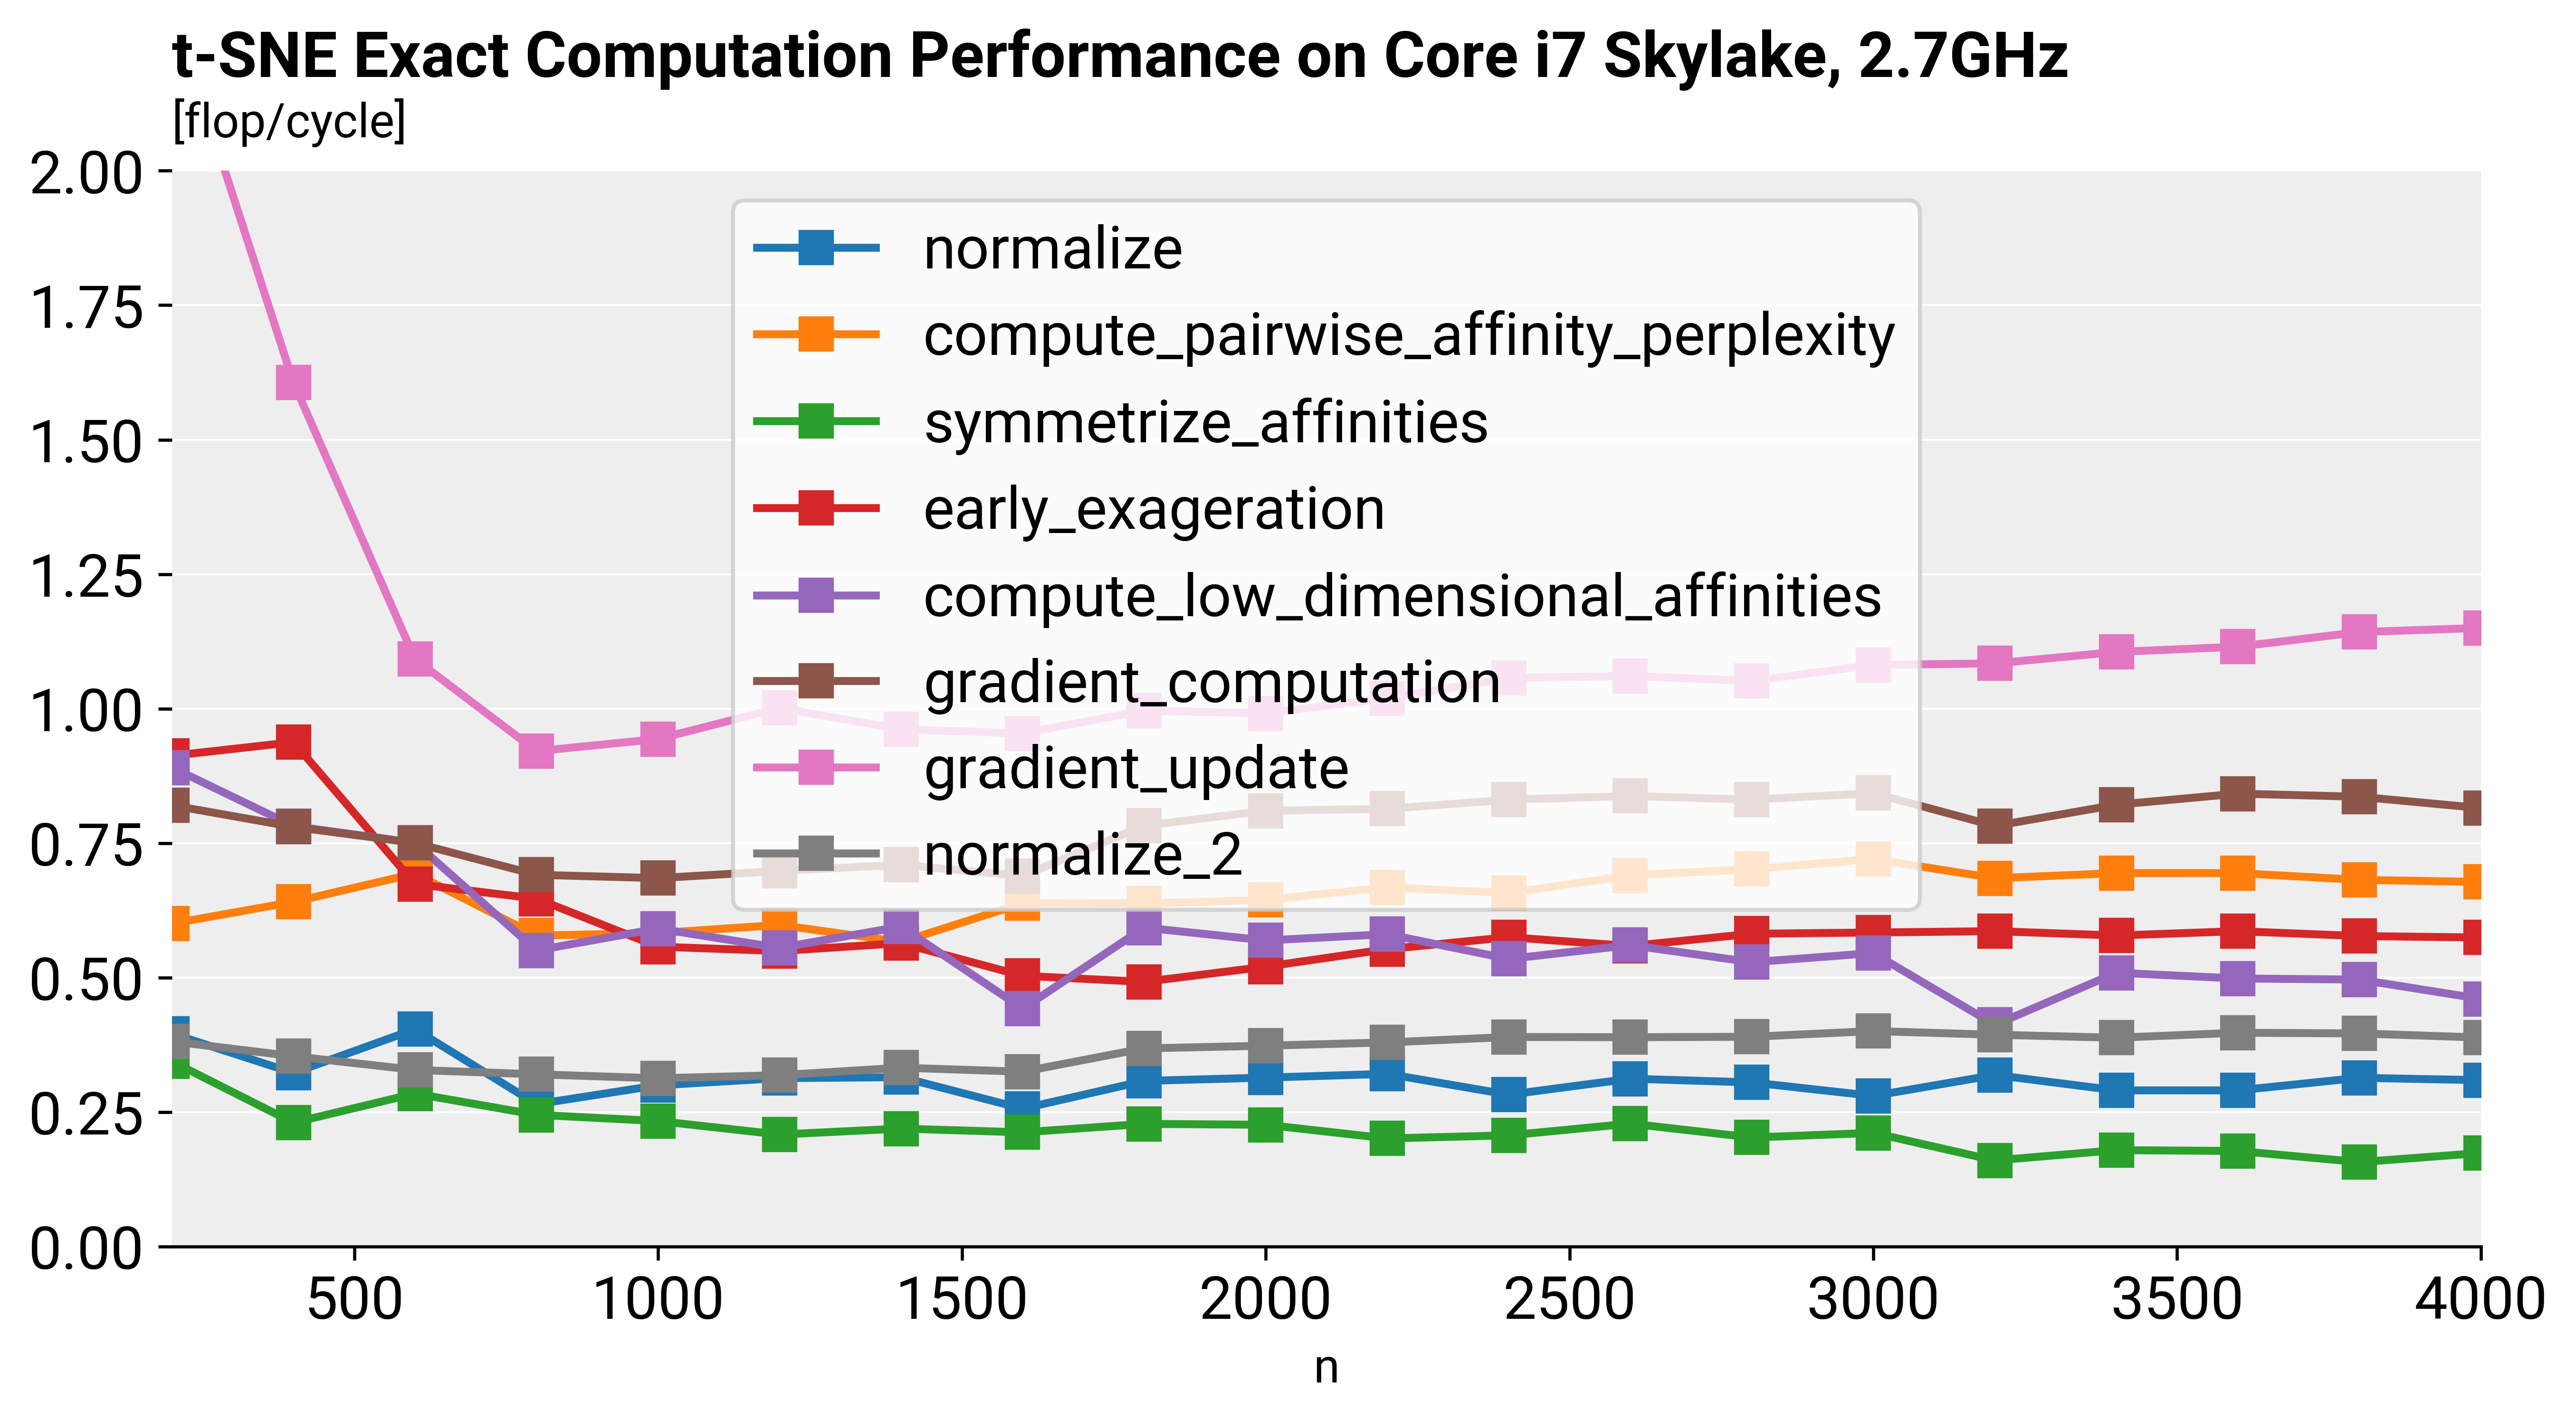

In [4]:
performance_by_function = flops_by_function / cycles[:,:-1]

title = "t-SNE Exact Computation Performance on Core i7 Skylake, 2.7GHz"
plot(N, performance_by_function.T, labels=FUNCTION_NAMES, title=title)
plt.show()

## $\mathcal{O}(n \log n)$

In [2]:
N, total_flops, flops_by_function, cycles = read_benchmark_bh("../implementations/tsne_nlogn/benchmarking/20170506_141917@-O3 -march=native@")

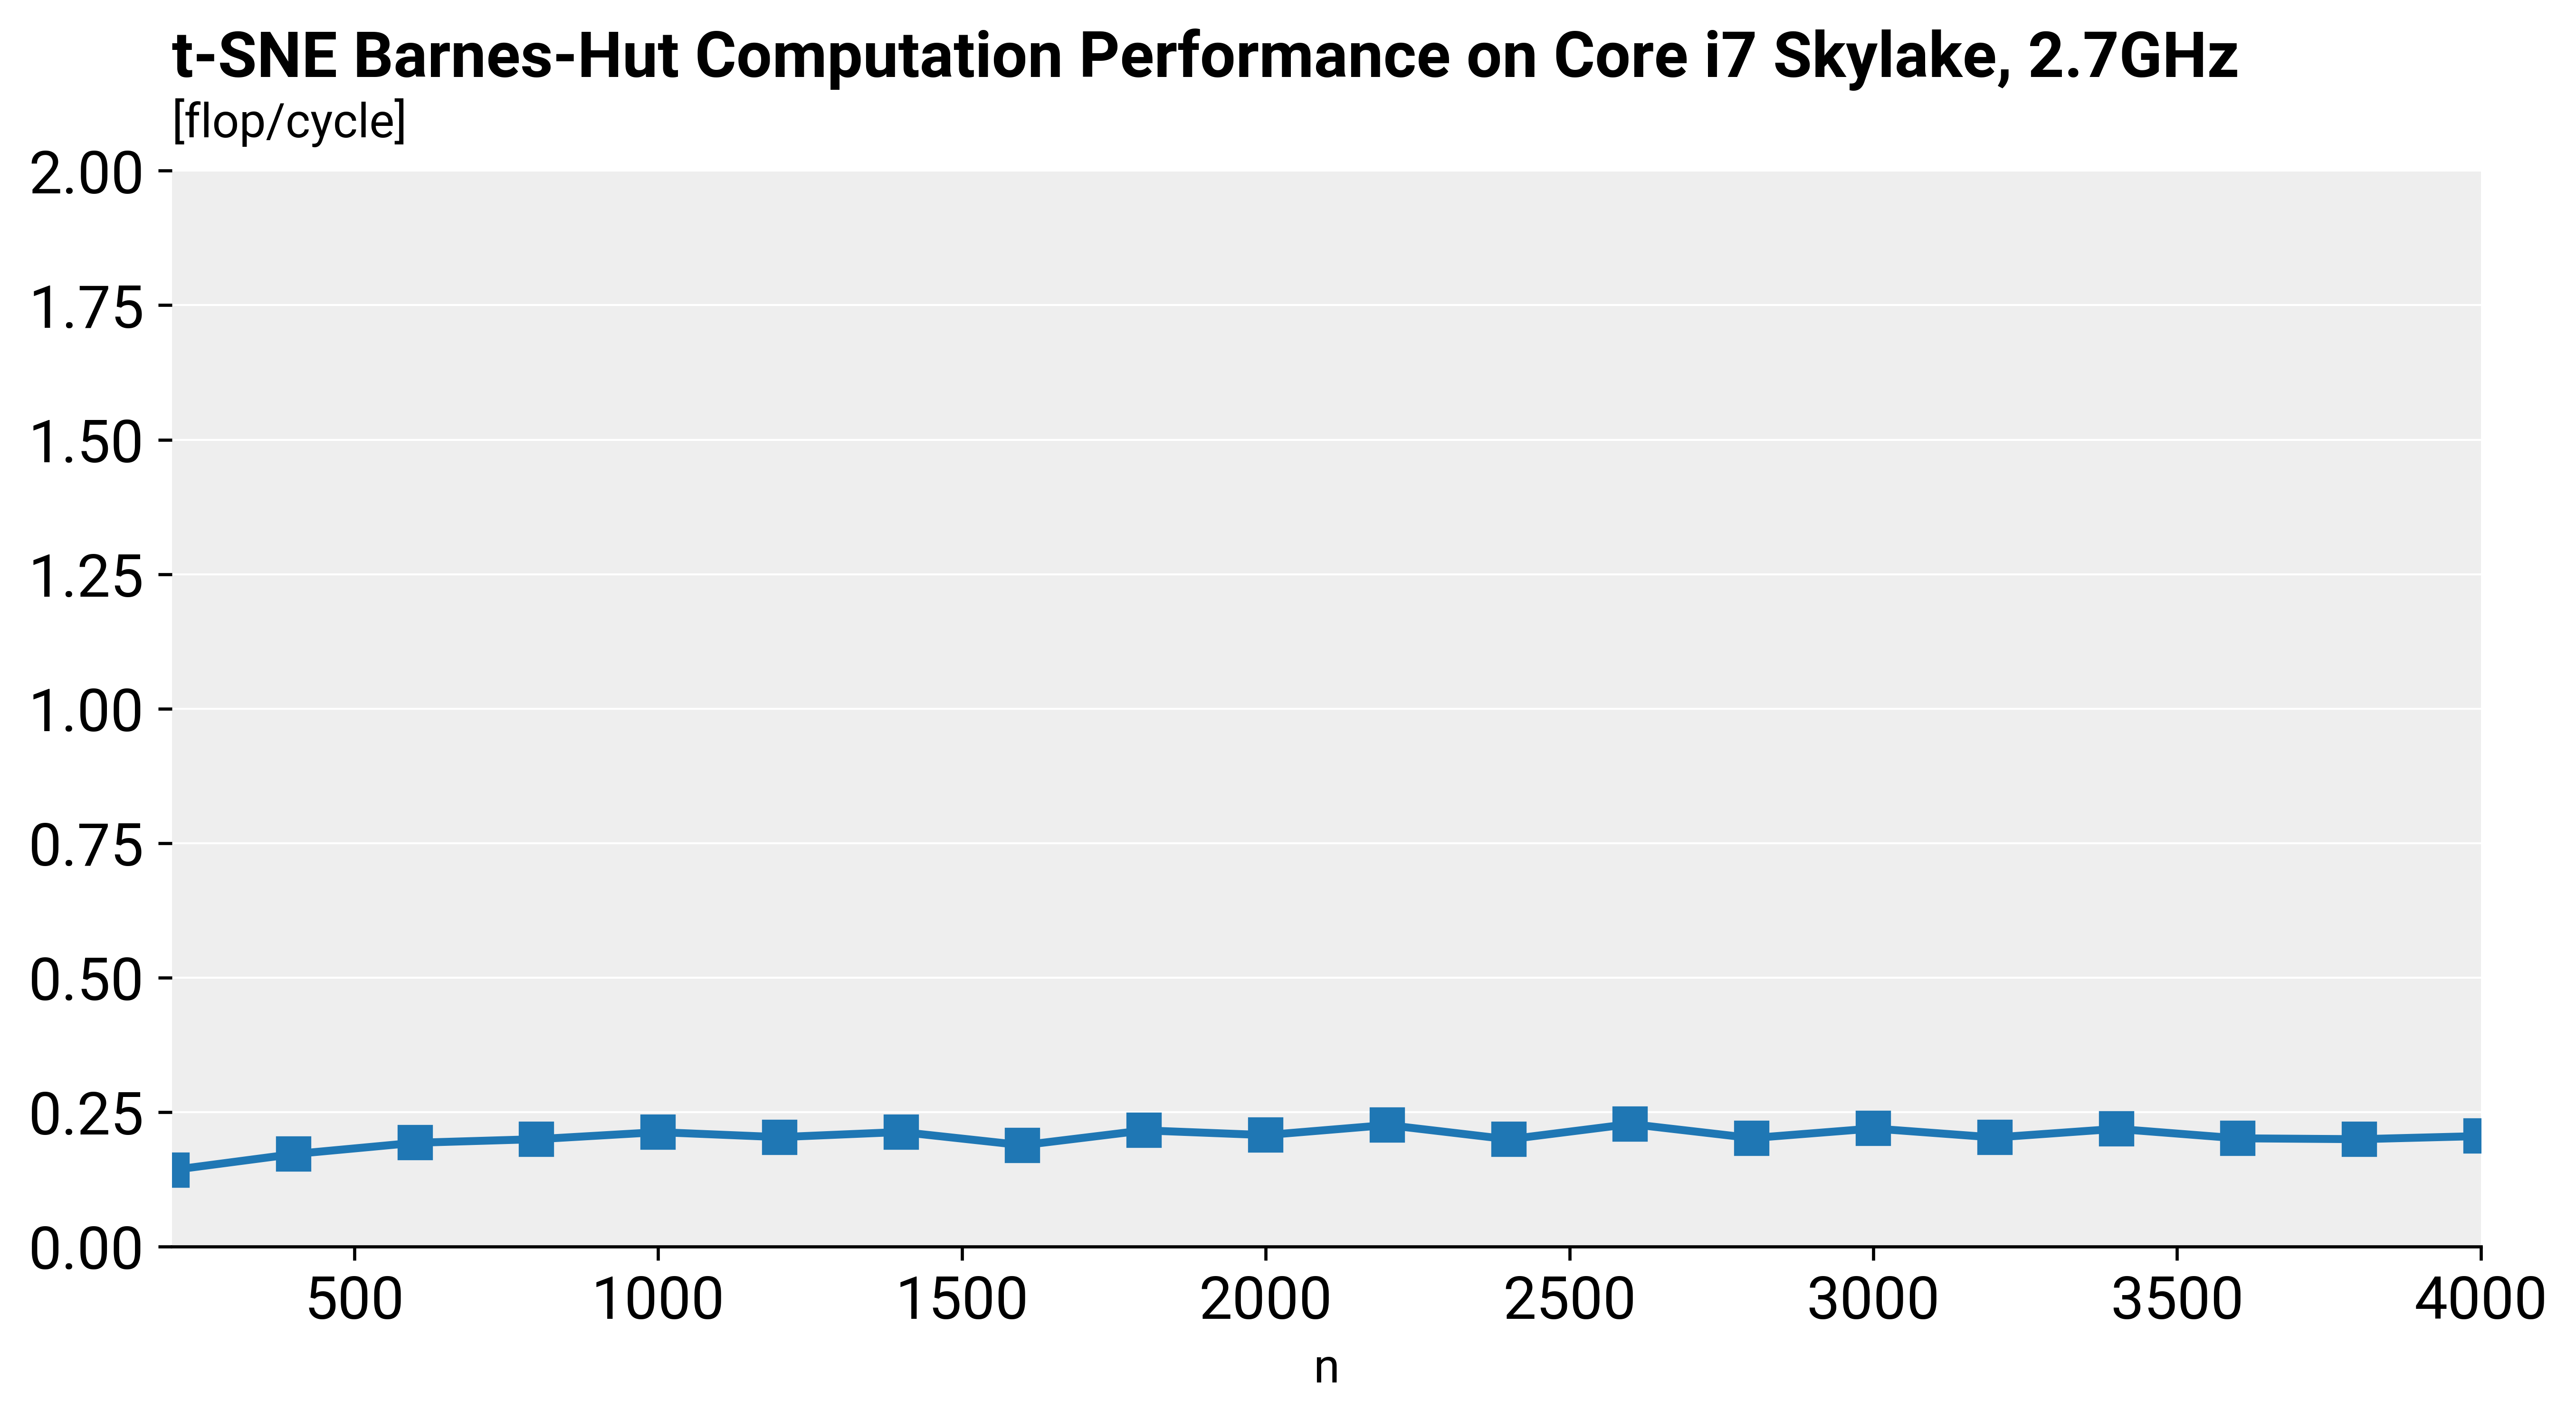

In [4]:
performance_total = total_flops / cycles[:,-1]

title = "t-SNE Barnes-Hut Computation Performance on Core i7 Skylake, 2.7GHz"
plot(N, performance_total, title=title)
plt.show()

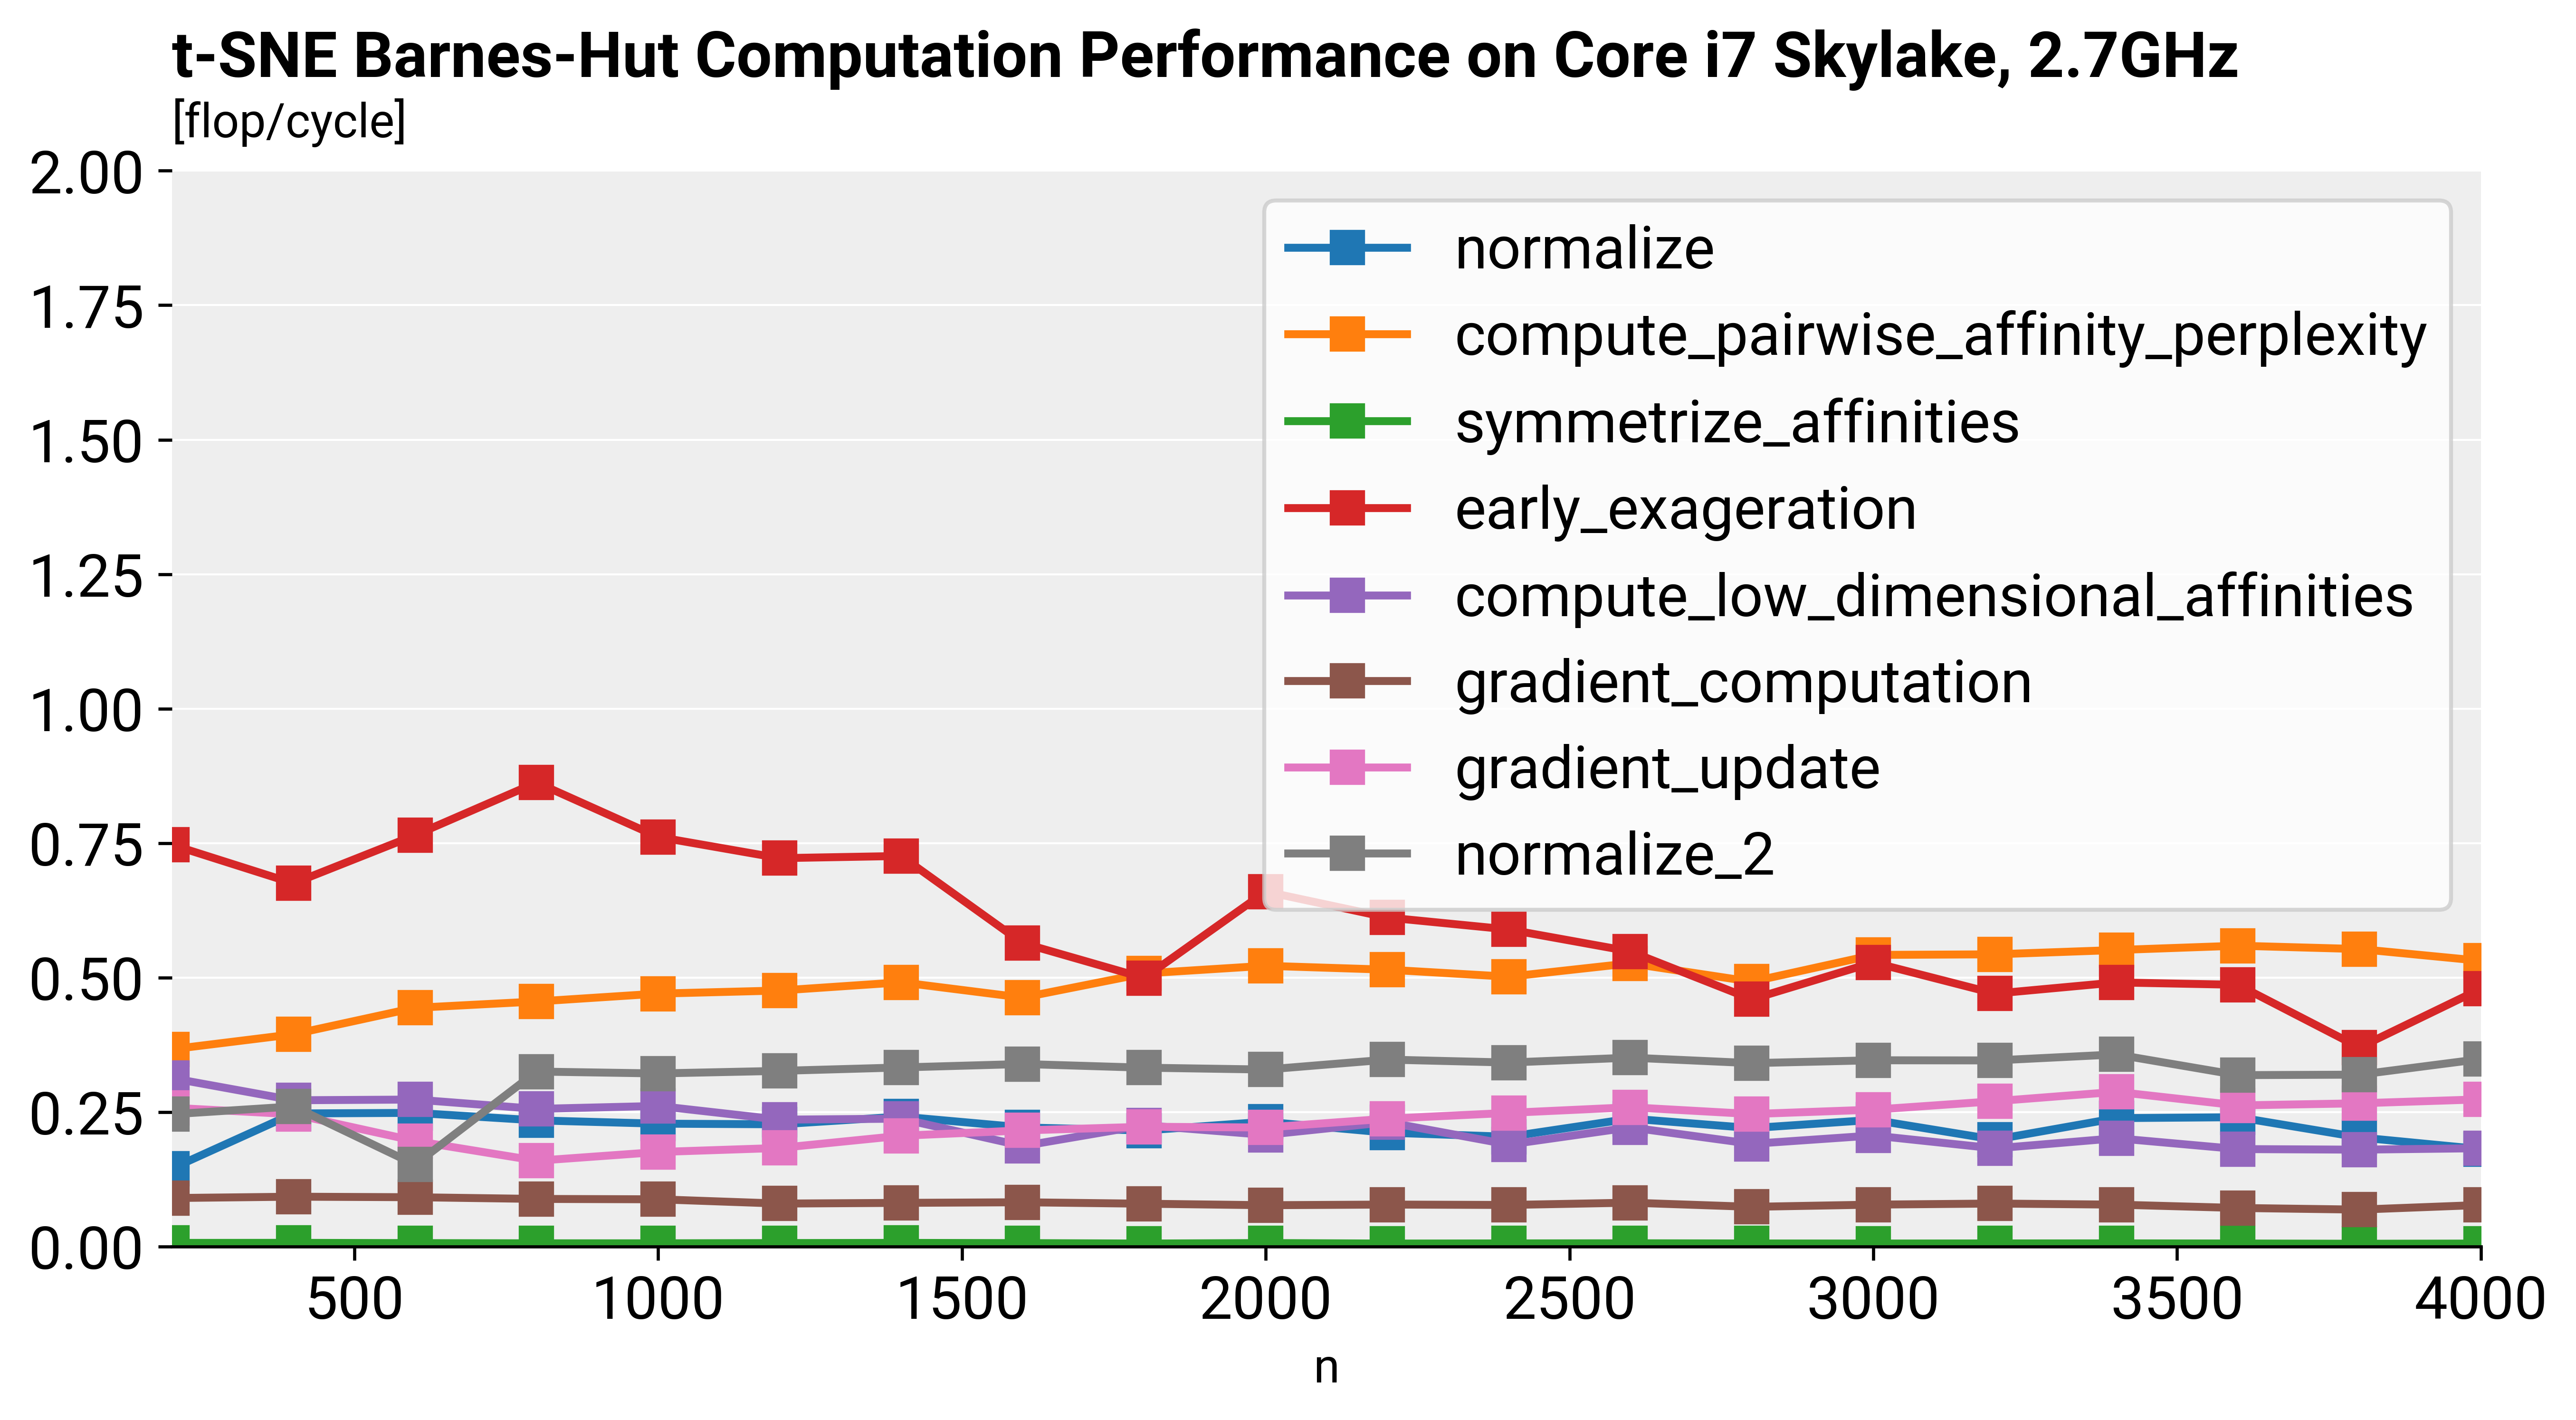

In [5]:
performance_by_function = flops_by_function / cycles[:,:-1]

title = "t-SNE Barnes-Hut Computation Performance on Core i7 Skylake, 2.7GHz"
plot(N, performance_by_function.T, labels=FUNCTION_NAMES, title=title)
plt.show()